In [356]:
from math import log,e,sqrt
import os
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

# Measuring peakiness

We want to look at the 'peakiness' of the distribution of PMI values for a given word.  Given a PMI matrix, where each row corresponds the the PMI of a given word with all the other words in the sentence, define peakiness as a function of a row of PMI values. $\text{peakiness}: \mathbb R^d \to \mathbb{R}[0,1]$


## Entropy-peakiness
One intuitive measure is to make a length-dependent version of (inverse) entropy:
$$
\text{peakiness}(v) 
= 1 - \frac{S(v) }{ \log(d) }
$$
where 
$$
S(v) = -\sum_{i \in v} 
\frac i {\sum_{j \in v} j} \log(\frac i {\sum_{j \in v} j}),
$$
the entropy of the row, normalized, treated as a probability vector.

In [393]:
def entropy(vec, base=None):
    """ Computes entropy of unnormalized vector of floats. """
    total = sum(vec)
    probs = [i / total for i in vec]
    entropy = 0.
    base = e if base is None else base
    for p in probs:
        if p < 0:
            ent_p = np.inf
        elif p == 0:
            ent_p = 0.
        else:
            ent_p = p * log(p, base)
        entropy -= ent_p

    return entropy

In [399]:
# examples
def peakiness_entropy(vec, absolute=False):
    if len(vec) == 1:
        return np.nan
    if absolute:
        vec = [abs(x) for x in vec]
    return 1 - entropy(vec) / log(len(vec))

examples = ([1,0,0,0],[0,0,1,1],[0,1,1,2],[1,1,1,1],
            [1,1,1,-1],[1],
            [0,1,1],[0,1,1,0,0],[0,1,1,0,0,0,0,0,0])

display(Math(r"\text{peakiness_entropy}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

One issue, however, if we are going to treat a sequence of PMI scores as a probability vector, is that PMI may be negative.  An intuitive way to do this still eludes me.  Shifting the values by the minimum value will not preserve the intuitive peakiness (for instance, taking $[0,0,0,-2]$ to $[2,2,2,0]$ becomes much 'flatter' than it should).  Taking the absolute value is better, but also doesn't seem right, since the distinction between positive and negative is meaningful (in taking $[0,0,1,-1]$ to $[0,0,1,1]$, we lose the information that the penultimate position has the maximum PMI).

So, with absolute value:

In [400]:
# examples with abs
display(Math(r"\text{peakiness_entropy_abs}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec, absolute=True)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


## Sparseness

Another option, is 'sparseness' defined as a relationship between the $L_1$ and $L_2$ norms of a vector, $\text{sparseness}: \mathbb R^d \to \mathbb R[0,1]$.

$$
\text{sparseness}(v) 
= \left({\sqrt{d} - \frac{\|v\|_{L_1}}{\|v\|_{L_2}} }\right)
/\left({\sqrt{d}-1}\right)
$$
from [Hoyer 2004](http://www.jmlr.org/papers/volume5/hoyer04a/hoyer04a.pdf) (§3.1)

In [401]:
def peakiness_sparseness(vec):
    d = len(vec)
    if d == 1:
        return np.nan
    abs_total = sum(abs(x) for x in vec)
    l2 = sqrt(sum(x**2 for x in vec))
    numerator = sqrt(d) - abs_total / l2
    return numerator / (sqrt(d) - 1)

In [402]:
# examples

display(Math(r"\text{peakiness_sparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_sparseness(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

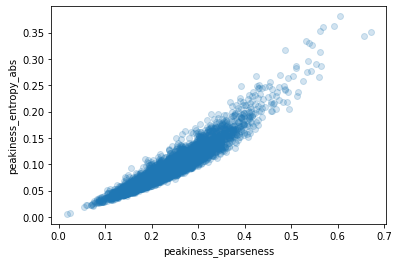

In [403]:
# comparing two measures

pairs = []
for i in range(500):
    # get a fake pmi matrix: 
    # a random square matrix size 5 to 30, populated with values in [-7,7]
    d = np.random.randint(25)+5
    pmis = 14 * np.random.sample((d,d)) - 7
    pmis = pmis + np.transpose(pmis) # symmetrize
    peakiness1 = np.apply_along_axis(peakiness_sparseness, axis=1, arr=pmis)
    peakiness2 = np.apply_along_axis(peakiness_entropy_abs, axis=1, arr=pmis)
    pairs += list(zip(peakiness1,peakiness2))

plt.scatter(*zip(*pairs),alpha = 0.2)
plt.xlabel('peakiness_sparseness')
plt.ylabel('peakiness_entropy_abs')
plt.show()

The for vectors in the middle range, 'entropy_abs' measure is generally a bit lower than 'sparseness', but they're probably going to be similar, pracically.

In [405]:
# example
RESULTS_DIR = "results/bert-base-cased(5)_pad10_2020-07-26-13-04/" 
npz = np.load(os.path.join(RESULTS_DIR, 'pmi_matrices.npz'))

for sentence, matrix in npz.items():
    sent = sentence.split(' ')
    print(f'{sent[0]}\tsparseness\tentropy_abs')
    matrix = matrix + np.transpose(matrix) # symmetrize
    for i, row in enumerate(matrix):
        row = row[np.arange(len(row))!=i] # remove diagonal
        print(f'\t{peakiness_sparseness(row):.6f}\t{peakiness_entropy_abs(row):.6f}\t{sent[i+1]}')
    print()

0	sparseness	entropy_abs
	0.255949	0.108780	Not
	0.151582	0.063596	his
	0.236582	0.103348	autograph
	0.320794	0.156162	;
	0.302822	0.111962	power-hitter
	0.254262	0.103325	McGwire
	0.475618	0.241796	's
	0.297435	0.140226	.

1	sparseness	entropy_abs
	0.001272	0.000538	Odds
	0.018666	0.007967	and
	0.010318	0.004384	Ends

2	sparseness	entropy_abs
	0.842950	0.570065	We
	0.437363	0.231653	're
	0.568438	0.318907	about
	0.828735	0.548923	to
	0.634230	0.351251	see
	0.539717	0.300614	if
	0.785636	0.491277	advertising
	0.713723	0.485138	works
	0.518812	0.323837	.

3	sparseness	entropy_abs
	nan	nan	FRANKFURT
	nan	nan	:

4	sparseness	entropy_abs
	0.537287	0.214588	Other
	0.398413	0.158602	brokerage
	0.610591	0.294270	firms
	0.375637	0.178441	,
	0.339397	0.144118	including
	0.932650	0.729205	Merrill
	0.921605	0.675302	Lynch
	0.952415	0.787273	&
	0.843990	0.496434	Co.
	0.501156	0.244575	,
	0.896107	0.593397	were
	0.691583	0.433138	plotting
	0.857996	0.593331	out
	0.793336	0.490848	potential
	0.55527

# Correlation with dependency accuracy

First, does average peakiness correlate with sentence-wide accuracy?

In [412]:
scores_path = glob.glob(RESULTS_DIR+'scores*')[0]
scores = pd.read_csv(scores_path)

av_sparseness = []
av_entropyabs = []
for sentence, matrix in npz.items():
    matrix = matrix + np.transpose(matrix) # symmetrize
    row_sparseness = []
    row_entropyabs = []
    for i, row in enumerate(matrix):
        row = row[np.arange(len(row))!=i] # remove diagonal
        row_sparseness.append(peakiness_sparseness(row))
        row_entropyabs.append(peakiness_entropy_abs(row))
    av_sparseness.append(np.mean(row_sparseness))
    av_entropyabs.append(np.mean(row_entropyabs))
    
scores["av_sparseness"] = av_sparseness
scores["av_entropyabs"] = av_entropyabs

In [413]:
scores

,sentence_index,sentence_length,number_edges,gold_edges,baseline_linear,baseline_random_nonproj,baseline_random_proj,pseudo_loglik,projective.edges.sum,projective.edges.triu,...,nonproj.edges.sum,nonproj.edges.triu,nonproj.edges.tril,nonproj.edges.none,nonproj.uuas.sum,nonproj.uuas.triu,nonproj.uuas.tril,nonproj.uuas.none,av_sparseness,av_entropyabs
0,0,8,5,"[(0, 2), (1, 2), (2, 5), (4, 5), (5, 6)]",0.600000,0.400000,0.600000,-78.871540,"[(0, 1), (1, 2), (2, 5), (2, 6), (4, 5)]","[(0, 6), (1, 2), (2, 4), (2, 5), (2, 6)]",...,"[(2, 6), (0, 1), (1, 2), (2, 5), (4, 5)]","[(2, 6), (0, 6), (1, 2), (0, 5), (1, 4)]","[(4, 5), (2, 4), (0, 1), (1, 2), (2, 6)]","[(5, 4), (2, 6), (4, 2), (1, 0), (0, 6)]",0.600000,0.200000,0.400000,0.200000,0.286881,0.128649
1,1,3,2,"[(0, 1), (0, 2)]",0.500000,1.000000,1.000000,-25.520242,"[(0, 1), (0, 2)]","[(0, 1), (0, 2)]",...,"[(0, 1), (0, 2)]","[(0, 1), (0, 2)]","[(0, 2), (1, 2)]","[(2, 0), (2, 1)]",1.000000,1.000000,0.500000,0.500000,0.010085,0.004296
2,2,9,7,"[(0, 2), (1, 2), (2, 4), (3, 4), (4, 7), (5, 7...",0.428571,0.285714,0.142857,-32.293420,"[(0, 1), (1, 5), (2, 3), (3, 4), (4, 5), (5, 7...","[(0, 1), (1, 4), (2, 3), (3, 4), (4, 5), (5, 7...",...,"[(5, 7), (4, 5), (6, 7), (0, 1), (3, 4), (1, 5...","[(5, 7), (4, 5), (0, 1), (6, 7), (1, 4), (2, 3...","[(5, 7), (4, 5), (6, 7), (3, 4), (0, 1), (1, 5...","[(7, 5), (5, 4), (7, 6), (4, 3), (0, 1), (5, 1...",0.571429,0.428571,0.571429,0.571429,0.652178,0.402407
3,3,2,0,[],NaN,NaN,NaN,-42.628381,[],[],...,[],[],[],[],NaN,NaN,NaN,NaN,NaN,NaN
4,4,18,14,"[(0, 2), (1, 2), (2, 4), (2, 11), (4, 6), (5, ...",0.500000,0.214286,0.357143,-43.948175,"[(0, 1), (1, 2), (1, 13), (4, 13), (5, 6), (5,...","[(0, 1), (1, 6), (1, 13), (2, 4), (4, 6), (5, ...",...,"[(11, 12), (5, 6), (11, 13), (7, 8), (10, 11),...","[(10, 11), (5, 6), (7, 8), (11, 13), (11, 12),...","[(11, 12), (11, 13), (5, 6), (7, 8), (13, 16),...","[(12, 11), (13, 11), (10, 11), (6, 5), (7, 8),...",0.428571,0.428571,0.428571,0.357143,0.648810,0.391239


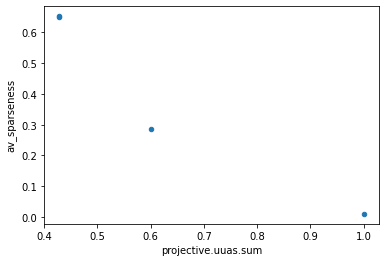

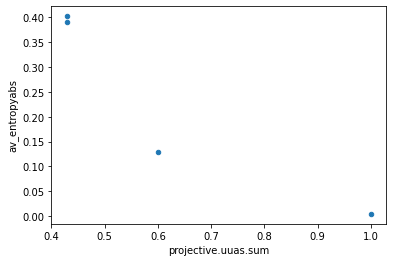

In [420]:
scores.plot.scatter(x='projective.uuas.sum', y='av_sparseness')
scores.plot.scatter(x='projective.uuas.sum', y='av_entropyabs')

In [383]:
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*')[0]
wordpair = pd.read_csv(wordpair_path)